# Exploración de fechas

In [1]:
# Importar librerias

In [2]:
import pandas as pd
from django.contrib.admin import display
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import calmap

In [3]:
# Cargar variables de entorno
load_dotenv()
db_url = os.getenv("DATABASE_URL")

In [4]:
# Conexión con la base de datos
engine = create_engine(db_url)

In [5]:
# Definir estilo de gráficos
sns.set_style("whitegrid")

# Rango de fechas

In [6]:
query_rango_fechas = """
SELECT MIN(fecha) AS primera_fecha, MAX(fecha) AS ultima_fecha FROM tiempo;
"""
df_rango_fechas = pd.read_sql(query_rango_fechas, con=engine)
display(df_rango_fechas)

,primera_fecha,ultima_fecha
0,2023-01-01,2034-05-30


La base de datos contiene información desde **2023-01-01** hasta **2025-03-31**, lo que nos indica que el período analizado abarca aproximadamente **2 años y 4 meses**. Esto es relevante porque permite conocer la cobertura temporal de los datos y verificar si hay periodos sin registros.  

# Distribución de ventas en el tiempo

## Ventas por año

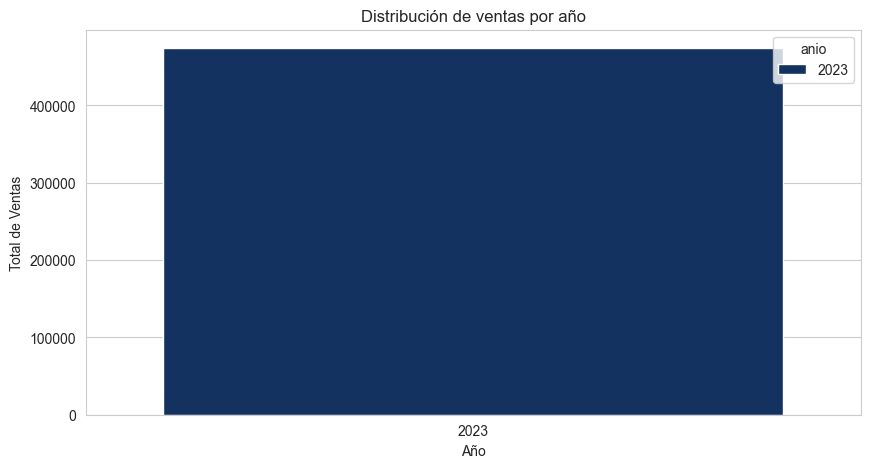

In [7]:
query_ventas_anio = """
SELECT anio, COUNT(*) AS total_ventas
FROM ventas
JOIN tiempo ON ventas.tiempo_id = tiempo.tiempo_id
GROUP BY anio
ORDER BY anio;
"""
df_ventas_anio = pd.read_sql(query_ventas_anio, con=engine)
display(df_ventas_anio)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_ventas_anio, x="anio",hue="anio", y="total_ventas", palette="Blues_r")
plt.title("Distribución de ventas por año")
plt.xlabel("Año")
plt.ylabel("Total de Ventas")
plt.show()



Los registros de ventas disponibles en la base de datos corresponden únicamente al año 2023, lo que sugiere que el análisis de ventas está limitado a este periodo. Es importante considerar esta restricción al interpretar las tendencias.

## Ventas por mes

In [8]:
query_ventas_mes = """
SELECT mes_nombre, COUNT(*) AS total_ventas
FROM ventas
JOIN tiempo ON ventas.tiempo_id = tiempo.tiempo_id
GROUP BY mes_nombre
ORDER BY total_ventas DESC;
"""
df_ventas_mes = pd.read_sql(query_ventas_mes, con=engine)
display(df_ventas_mes)


,mes_nombre,total_ventas
0,August,42387
1,January,42345
2,October,42333
3,July,42310
4,March,42283
5,May,42261
6,June,41009
7,April,40983
8,November,40967
9,September,40918


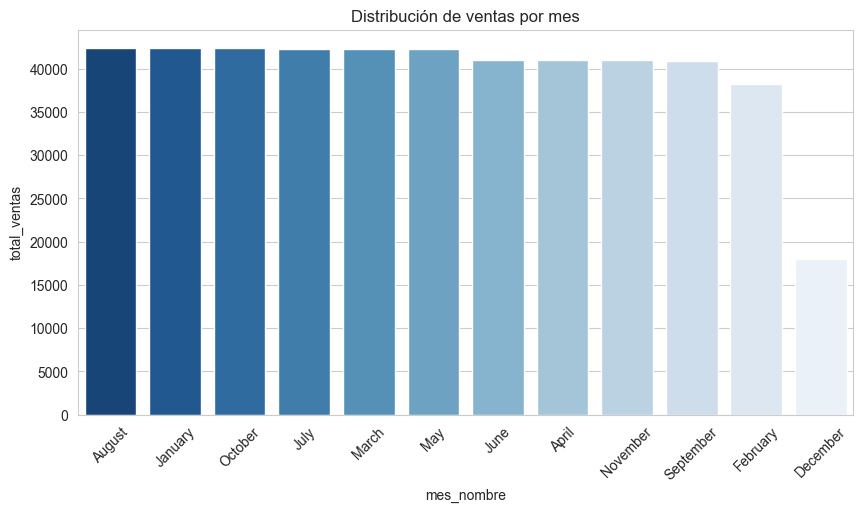

In [9]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_ventas_mes, x="mes_nombre", hue="mes_nombre", y="total_ventas", palette="Blues_r")
plt.title("Distribución de ventas por mes")
plt.xticks(rotation=45)
plt.show()

Se observa que la primera mitad del año presenta un volumen alto de ventas, con agosto liderando el ranking. Sin embargo, hacia el final del año, la cantidad de ventas disminuye. Esto podría indicar factores estacionales o estrategias comerciales específicas. El comportamiento decreciente en los últimos meses del año podría estar relacionado con cambios en la demanda, menor disponibilidad de productos o estrategias comerciales específicas.


## Ventas por día de la semana

In [10]:
query_ventas_dia = """
SELECT tiempo.dia_nombre, COUNT(*) AS total_ventas
FROM ventas
JOIN tiempo ON ventas.tiempo_id = tiempo.tiempo_id
GROUP BY tiempo.dia_nombre
ORDER BY total_ventas DESC;
"""
df_ventas_dia = pd.read_sql(query_ventas_dia, con=engine)
display(df_ventas_dia)

,dia_nombre,total_ventas
0,Wednesday,68282
1,Sunday,68243
2,Monday,68236
3,Tuesday,68217
4,Thursday,67236
5,Saturday,67002
6,Friday,66870


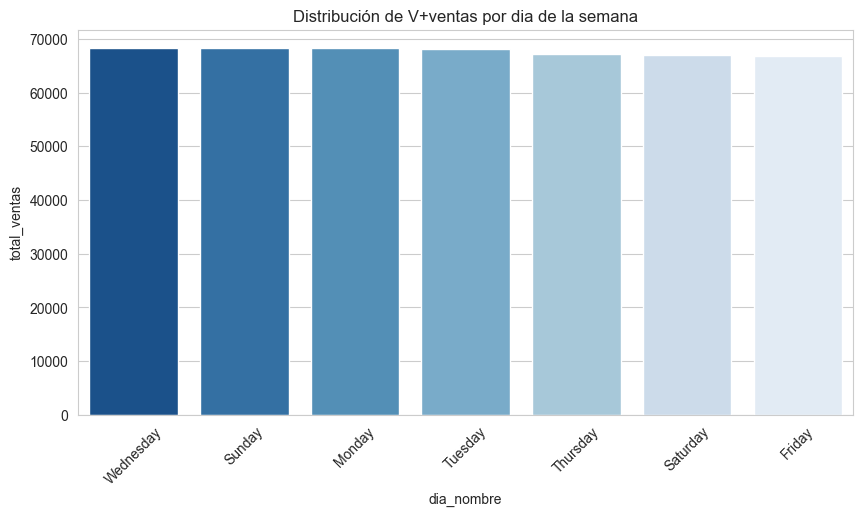

In [11]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_ventas_dia, x="dia_nombre", hue="dia_nombre", y="total_ventas", palette="Blues_r")
plt.title("Distribución de V+ventas por dia de la semana")
plt.xticks(rotation=45)
plt.show()

En general, las ventas se mantienen constantes a lo largo de la semana. Sin embargo, los domingos y los miércoles registran un volumen ligeramente superior. Esto podría estar relacionado con promociones específicas o patrones de compra de los clientes.

## Ventas por hora del día

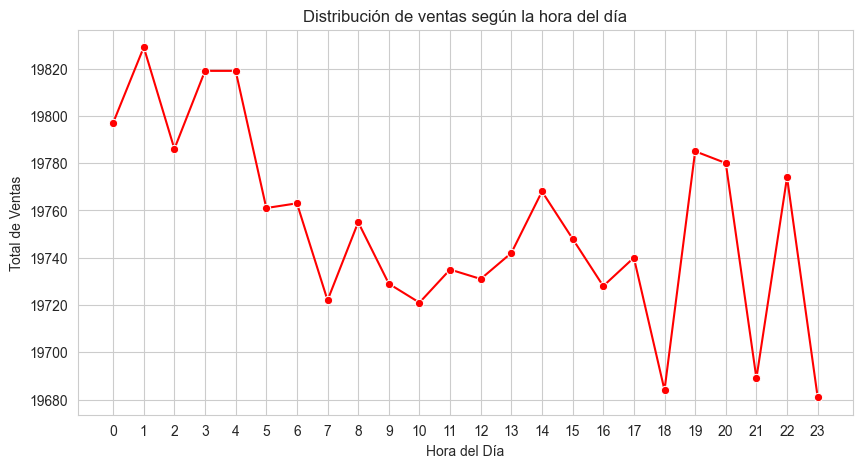

In [12]:
query_ventas_hora = """
SELECT EXTRACT(HOUR FROM t.hora::TIME) AS hora_del_dia, COUNT(*) AS total_ventas
FROM ventas v
JOIN tiempo t ON v.tiempo_id = t.tiempo_id
GROUP BY hora_del_dia
ORDER BY hora_del_dia;
"""
df_ventas_hora = pd.read_sql(query_ventas_hora, con=engine)
display(df_ventas_hora)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_ventas_hora, x="hora_del_dia", y="total_ventas", marker="o", color="red")
plt.xticks(range(0, 24))
plt.xlabel("Hora del Día")
plt.ylabel("Total de Ventas")
plt.title("Distribución de ventas según la hora del día")
plt.grid(True)
plt.show()

El análisis de las ventas por hora muestra una distribución bastante variada. Se observan tres picos importantes:

- **De 00:00 a 04:00**: Se registra el mayor volumen de ventas del día.
- **14:00 horas**: Se presenta un ligero aumento en las ventas.
- **20:00 y 22:00 horas**: Se observan picos menores en la actividad comercial.

Después de las 04:00 horas, las ventas disminuyen y permanecen estables hasta la tarde, cuando se observan nuevos aumentos.


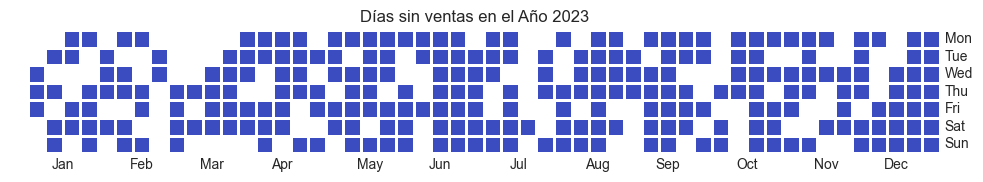

In [13]:
query_fechas_sin_ventas = """
SELECT t.fecha FROM tiempo t
LEFT JOIN ventas v ON t.tiempo_id = v.tiempo_id
WHERE v.tiempo_id IS NULL
ORDER BY t.fecha;
"""
df_fechas_sin_ventas = pd.read_sql(query_fechas_sin_ventas, con=engine)
df_fechas_sin_ventas["fecha"] = pd.to_datetime(df_fechas_sin_ventas["fecha"])
df_fechas_sin_ventas["actividad"] = 0

plt.figure(figsize=(12, 5))
calmap.yearplot(df_fechas_sin_ventas.set_index("fecha")["actividad"], cmap="coolwarm", fillcolor="white")
plt.title("Días sin ventas en el Año 2023")
plt.show()

El análisis de días sin ventas revela que los primeros tres meses del año presentan varias fechas sin actividad comercial, particularmente de lunes a miércoles. Además, en julio se identifica una semana en la que solo se registraron ventas un solo día. Esto sugiere posibles interrupciones operativas o menor demanda en ciertos periodos.


# Distribución de los envíos en el tiempo

## Envíos por año

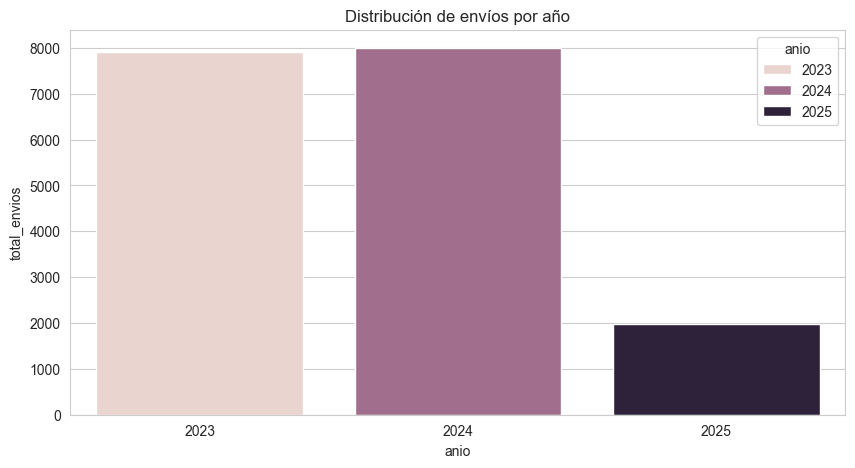

In [14]:
query_envios_anio = """
SELECT t.anio, COUNT(*) AS total_envios
FROM envios e
JOIN tiempo t ON e.tiempo_id = t.tiempo_id
GROUP BY t.anio
ORDER BY t.anio;
"""
df_envios_anio = pd.read_sql(query_envios_anio, con=engine)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_envios_anio, x="anio", hue="anio", y="total_envios")
plt.title("Distribución de envíos por año")
plt.show()

Se observa que el año con mayor cantidad de envíos registrados es 2024, seguido por 2023. Sin embargo, un hallazgo interesante es que en 2025 aún hay registros de envíos, a pesar de que las ventas solo están documentadas hasta 2023. Esto podría indicar que los envíos se programan con anticipación o que existen inconsistencias en la captura de datos.


## Envíos por mes

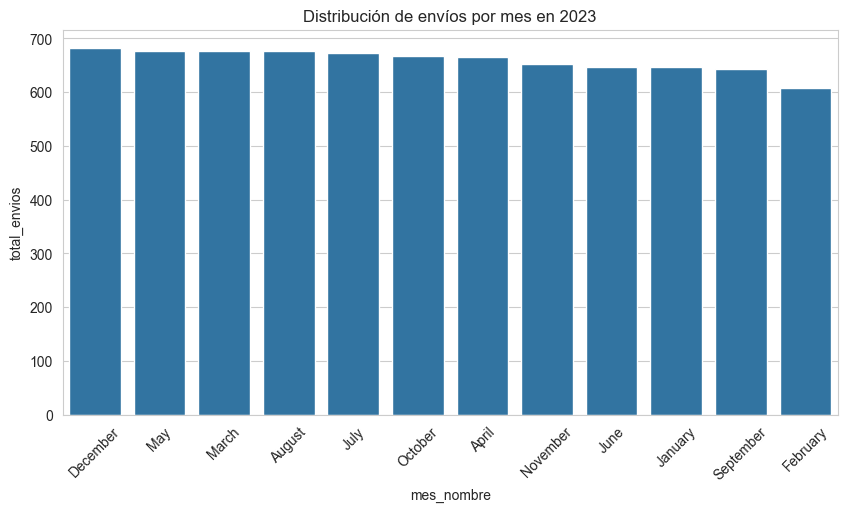

In [15]:
query_envios_mes = """
SELECT t.mes_nombre, COUNT(*) AS total_envios
FROM envios e
JOIN tiempo t ON e.tiempo_id = t.tiempo_id
where t.anio=2023
GROUP BY t.mes_nombre
ORDER BY total_envios DESC;
"""
df_envios_mes = pd.read_sql(query_envios_mes, con=engine)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_envios_mes, x="mes_nombre", y="total_envios")
plt.title("Distribución de envíos por mes en 2023")
plt.xticks(rotation=45)
plt.show()

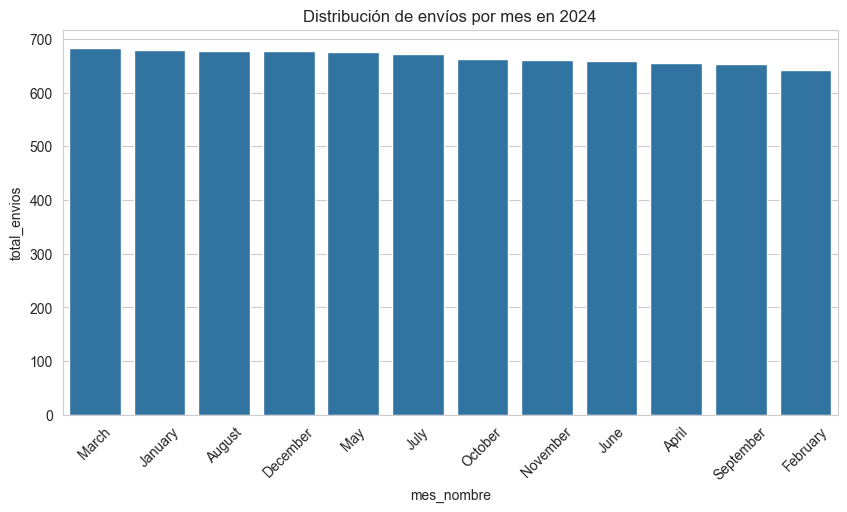

In [16]:
query_envios_mes = """
SELECT t.mes_nombre, COUNT(*) AS total_envios
FROM envios e
JOIN tiempo t ON e.tiempo_id = t.tiempo_id
where t.anio=2024
GROUP BY t.mes_nombre
ORDER BY total_envios DESC;
"""
df_envios_mes = pd.read_sql(query_envios_mes, con=engine)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_envios_mes, x="mes_nombre", y="total_envios")
plt.title("Distribución de envíos por mes en 2024")
plt.xticks(rotation=45)
plt.show()

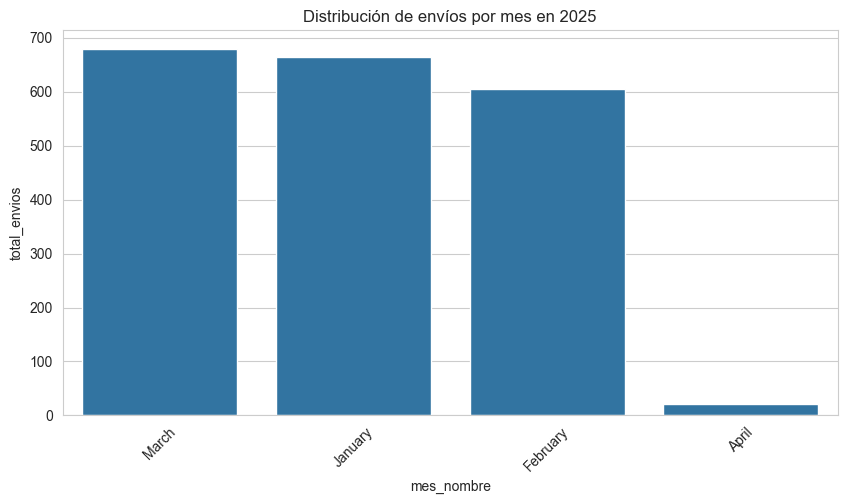

In [17]:
query_envios_mes = """
SELECT t.mes_nombre, COUNT(*) AS total_envios
FROM envios e
JOIN tiempo t ON e.tiempo_id = t.tiempo_id
where t.anio=2025
GROUP BY t.mes_nombre
ORDER BY total_envios DESC;
"""
df_envios_mes = pd.read_sql(query_envios_mes, con=engine)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_envios_mes, x="mes_nombre", y="total_envios")
plt.title("Distribución de envíos por mes en 2025")
plt.xticks(rotation=45)
plt.show()

Al centrarnos únicamente en los registros de 2023, se observa que diciembre es el mes con mayor volumen de envíos, seguido de mayo. Por otro lado, los meses con menor cantidad de envíos son septiembre y febrero. 


## Envíos por día de la semana

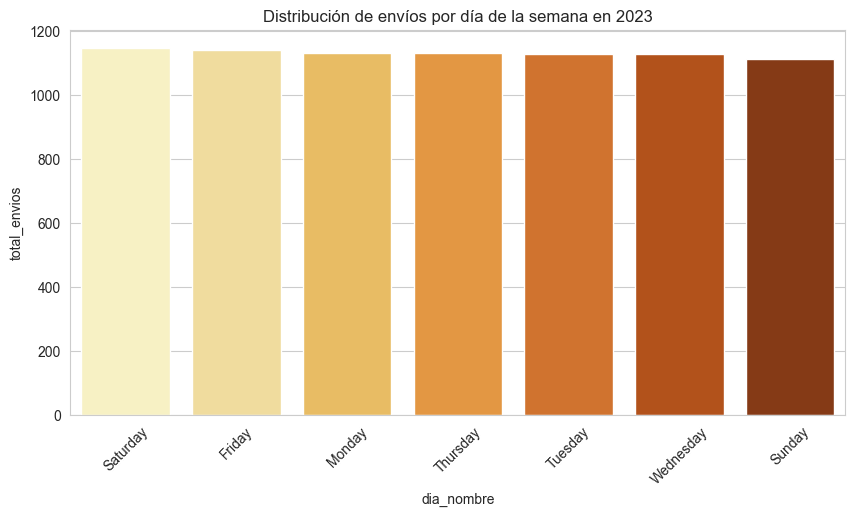

In [18]:
query_envios_dia = """
SELECT t.dia_nombre, COUNT(*) AS total_envios
FROM envios e
JOIN tiempo t ON e.tiempo_id = t.tiempo_id
where t.anio=2023
GROUP BY t.dia_nombre
ORDER BY total_envios DESC;
"""
df_envios_dia = pd.read_sql(query_envios_dia, con=engine)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_envios_dia, x="dia_nombre",hue="dia_nombre", y="total_envios", palette="YlOrBr")
plt.title("Distribución de envíos por día de la semana en 2023")
plt.xticks(rotation=45)
plt.show()

A diferencia de las ventas, los días con más envíos son los viernes y sábados, mientras que los domingos y miércoles tienen la menor cantidad. Esta diferencia entre ventas y envíos puede indicar que las entregas no se realizan inmediatamente después de la compra.


## Envíos por la hora del día

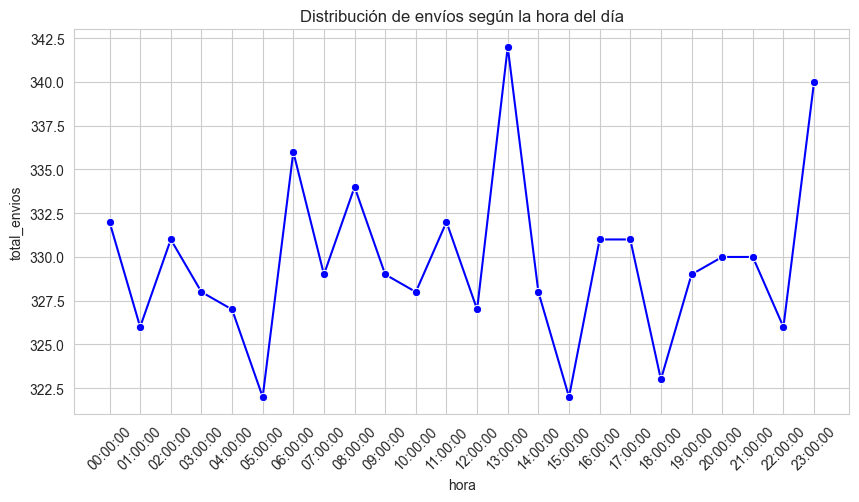

In [19]:
query_envios_hora = """
SELECT t.hora, COUNT(*) AS total_envios
FROM envios e
JOIN tiempo t ON e.tiempo_id = t.tiempo_id
where t.anio=2023
GROUP BY t.hora
ORDER BY t.hora;
"""
df_envios_hora = pd.read_sql(query_envios_hora, con=engine)

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_envios_hora, x="hora", y="total_envios", marker="o", color="blue")
plt.title("Distribución de envíos según la hora del día")
plt.xticks(rotation=45)
plt.show()

El análisis por hora muestra que el menor número de envíos ocurre a las 05:00 horas. El pico más alto de envíos se registra a medio día (12:00 horas), con otro aumento importante a las 23:00 horas.


## Dias del año 2023 sin envíos

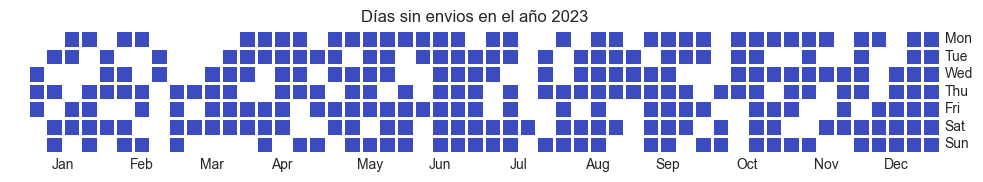

In [20]:
query_fechas_sin_envios = """
SELECT t.fecha FROM tiempo t
LEFT JOIN envios e ON t.tiempo_id = e.tiempo_id
WHERE e.tiempo_id IS NULL AND t.anio=2023
ORDER BY t.fecha;
"""
query_fechas_sin_envios = pd.read_sql(query_fechas_sin_envios, con=engine)
query_fechas_sin_envios["fecha"] = pd.to_datetime(query_fechas_sin_envios["fecha"])
query_fechas_sin_envios["actividad"] = 0

plt.figure(figsize=(12, 5))
calmap.yearplot(df_fechas_sin_ventas.set_index("fecha")["actividad"], cmap="coolwarm", fillcolor="white")
plt.title("Días sin envios en el año 2023")
plt.show()

Se observa que en los primeros tres meses del año hubo múltiples días sin envíos, especialmente de lunes a miércoles. Además, se repite el patrón identificado en ventas, donde en julio hubo una semana con actividad muy reducida.
